# Connect to Database

In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import yellowbrick as yb

from yellowbrick.features import RadViz
from sklearn.metrics import accuracy_score
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.features import FeatureImportances
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def connectDB(DB):
    # connect to the PostgreSQL server
    return psycopg2.connect(
        database=DB,
        user="postgres",
        password="Georgetown16",
        host="database-1.c5vispb5ezxg.us-east-1.rds.amazonaws.com",
        port='5432')

def disconnectDB():
    cur.close()
    conn.close()

In [3]:
conn = connectDB("Dataset")

# extract everything from 'table_name' into a dataframe
df = pd_sql.read_sql(f"select * from public.\"FinalData_ForFeatures\" ", con=conn)
#code to be able to view all the columns in pandas dataframe
pd.set_option('display.max_columns', 50)       

# Feature Analysis for STEM 2013

In [4]:
df = df[['code_module', 
         'module_domain', 
         'module_presentation_length',
         'year',
         'term', 
         'num_of_prev_attempts',
         'final_result', 
         'date_registration', 
         'disability', 
         'gender', 
         'age_band', 
         'region', 
         'highest_education', 
         'imd_band', 
         'studied_credits', 
         'b4_sum_clicks', 
         'half_sum_clicks', 
         'std_half_score'
        ]]

In [5]:
feature_list = df

In [6]:
#remove null values
#feature_list = feature_list.dropna()

In [7]:
feature_list.head()

,code_module,module_domain,module_presentation_length,year,term,num_of_prev_attempts,final_result,date_registration,disability,gender,age_band,region,highest_education,imd_band,studied_credits,b4_sum_clicks,half_sum_clicks,std_half_score
0,3,1,261,0,0,0,0,-68.0,0,0,2,3,3,9.0,60,0.0,0.0,0.000000
1,0,0,269,1,0,0,1,-52.0,0,0,2,0,3,8.0,60,256.0,1347.0,56.400000
2,3,1,261,0,0,0,0,-137.0,0,0,2,2,3,3.0,90,81.0,565.0,58.166667
3,3,1,262,1,0,1,0,-38.0,0,0,2,2,3,3.0,60,0.0,0.0,0.000000
4,0,0,268,0,0,0,1,-159.0,0,0,2,1,3,9.0,240,98.0,612.0,81.600000


In [8]:
feature_list = df.loc[(df.year == 0)&(df.module_domain==0)]

In [9]:
feature_list = feature_list[feature_list.columns.drop(['module_domain', 'year', 'term'])]

In [10]:
feature_list.head()

,code_module,module_presentation_length,num_of_prev_attempts,final_result,date_registration,disability,gender,age_band,region,highest_education,imd_band,studied_credits,b4_sum_clicks,half_sum_clicks,std_half_score
4,0,268,0,1,-159.0,0,0,2,1,3,9.0,240,98.0,612.0,81.600000
5,1,240,2,0,-47.0,0,1,0,1,1,2.0,60,14.0,147.0,38.813953
6,1,268,0,0,-194.0,0,1,0,1,2,4.0,60,0.0,0.0,0.000000
8,1,268,0,1,-27.0,0,0,0,9,2,5.0,60,6.0,365.0,89.612903
12,6,261,0,1,-64.0,0,0,0,7,2,8.0,30,0.0,263.0,0.000000


# Feature Selection

In [11]:
#pick out the 5 features to examine relationship
X = feature_list[["half_sum_clicks","gender", "highest_education", "code_module", "studied_credits"]].values
        
#define target variable
y = feature_list["final_result"].values

Radviz Visualization

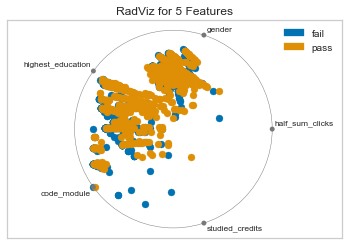

In [12]:
classes = ["fail", "pass"]
features = ["half_sum_clicks", "gender", "highest_education", "code_module", "studied_credits"]
        
sns.set_palette("colorblind")
# Instantiate the visualizer
visualizer = RadViz (
    classes=classes,
    features = features
)

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

Pairplots: note that the hue is final_result which is now mapped to a binary classification

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


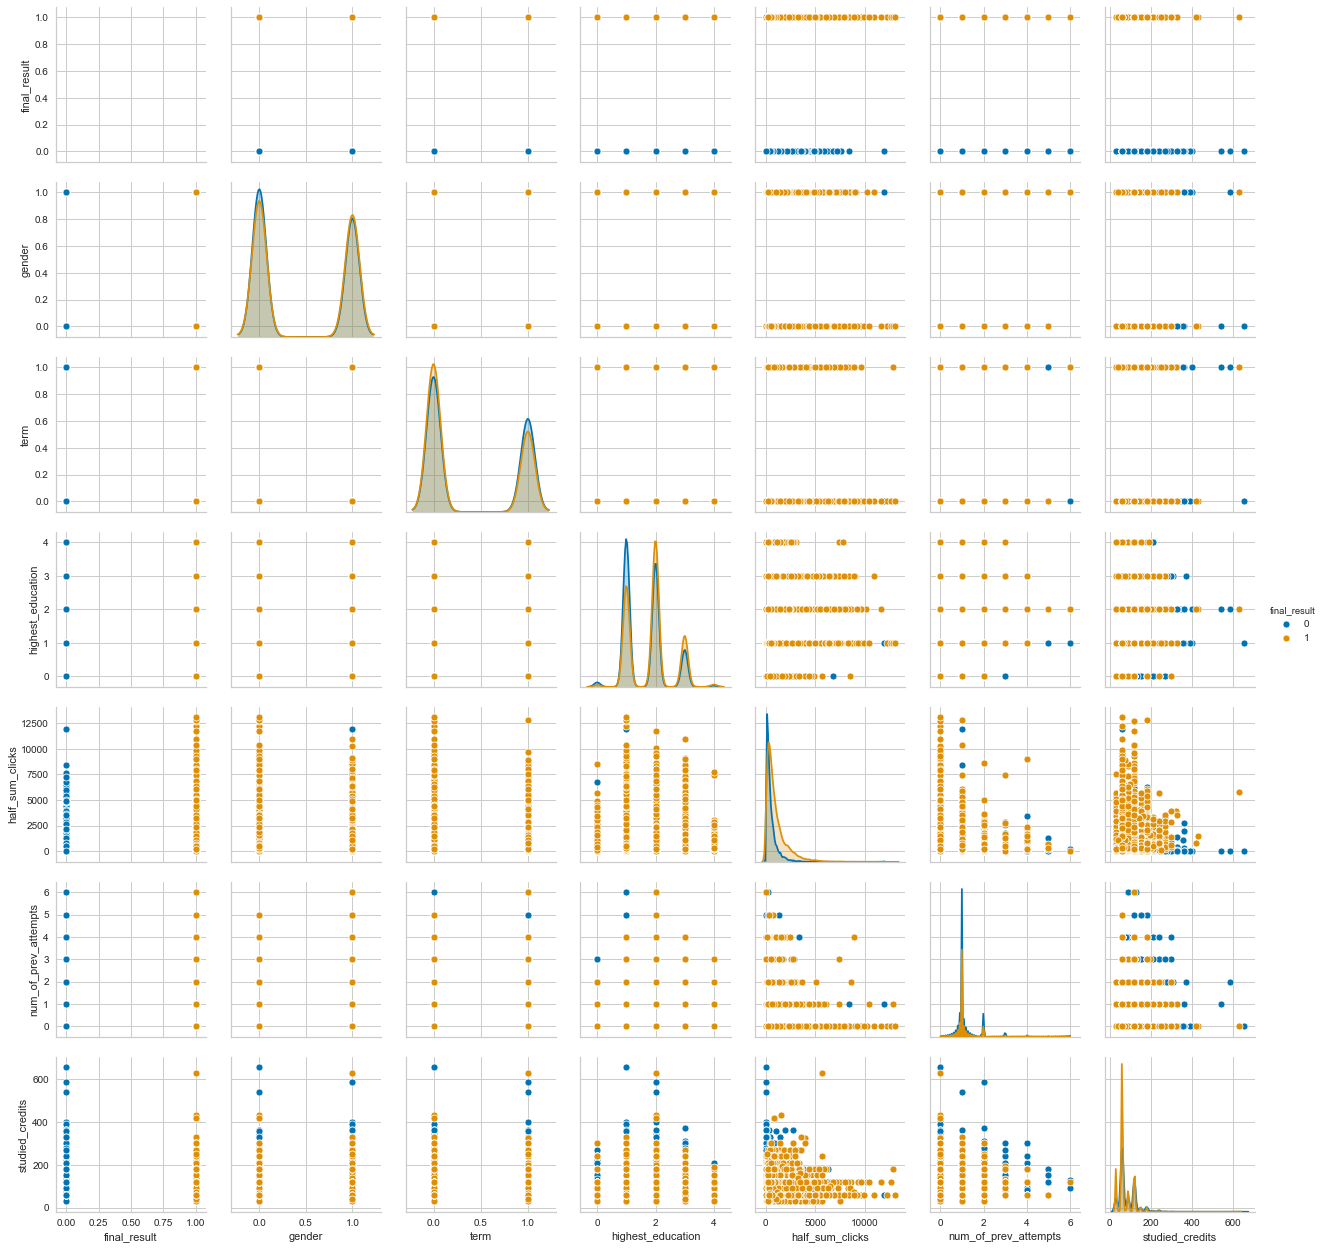

In [13]:
df_plot = df[["final_result","gender", "term", "highest_education", "half_sum_clicks","num_of_prev_attempts", "studied_credits"]]
g = sns.pairplot(df_plot, hue="final_result")
plt.show()

In [14]:
#printing out to check the y variable was filled
y

array([1, 0, 0, ..., 0, 1, 1])

# Feature Analysis Ranking

Shapiro Feature Ranking

//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:

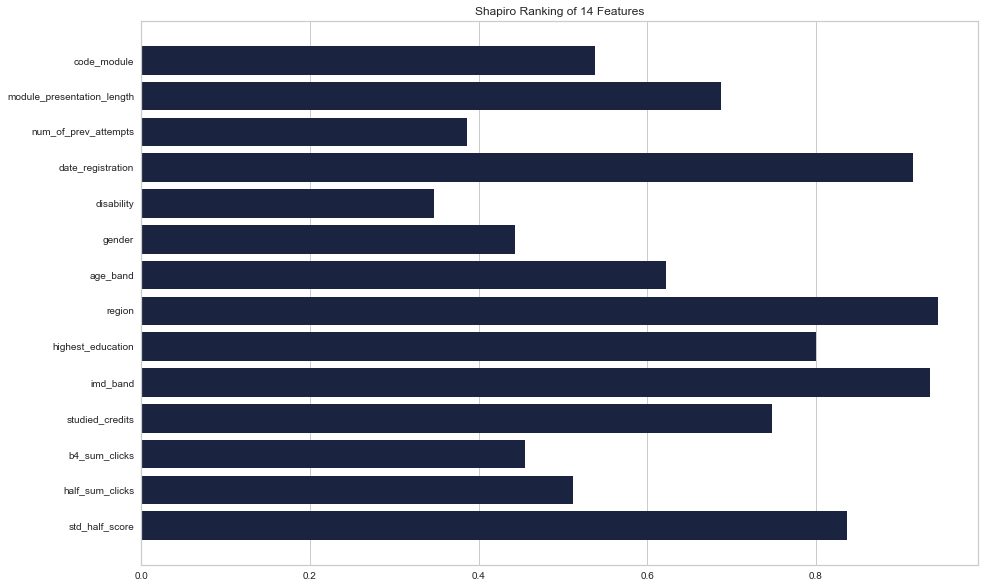

In [15]:
sns.set_palette("cubehelix")

X = feature_list[feature_list.columns.drop(['final_result'])]

y = feature_list['final_result']

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro',size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

RandomForest Classifier Feature Ranking

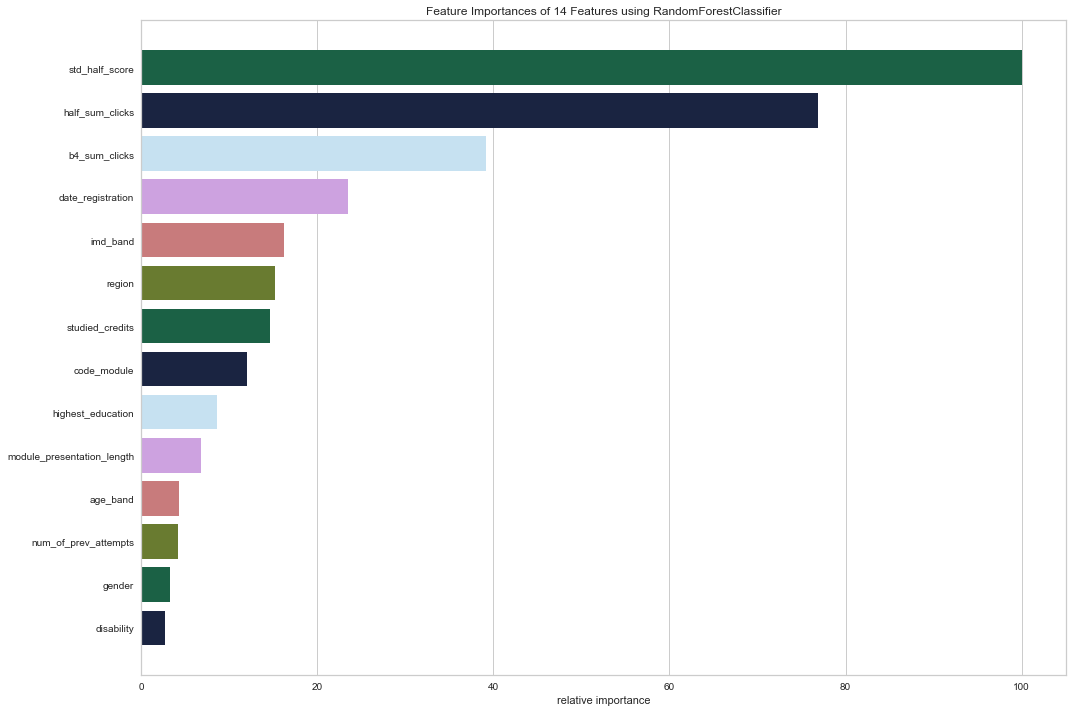

In [16]:
model = RandomForestClassifier(n_estimators=10)
feature_list = FeatureImportances(model, size=(1080, 720))
feature_list.fit(X, y)

feature_list.show()

LogisticRegression Feature Ranking

//anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


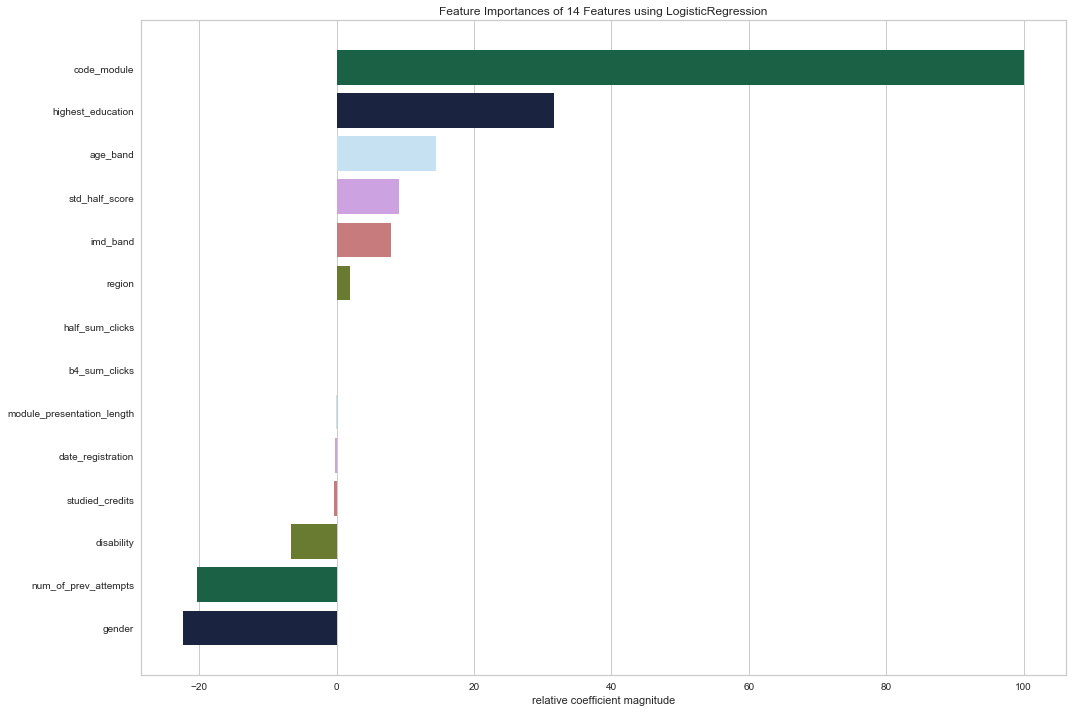

In [17]:
model = LogisticRegression()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)

viz.show()

DecisionTreeClassifier Feature Ranking

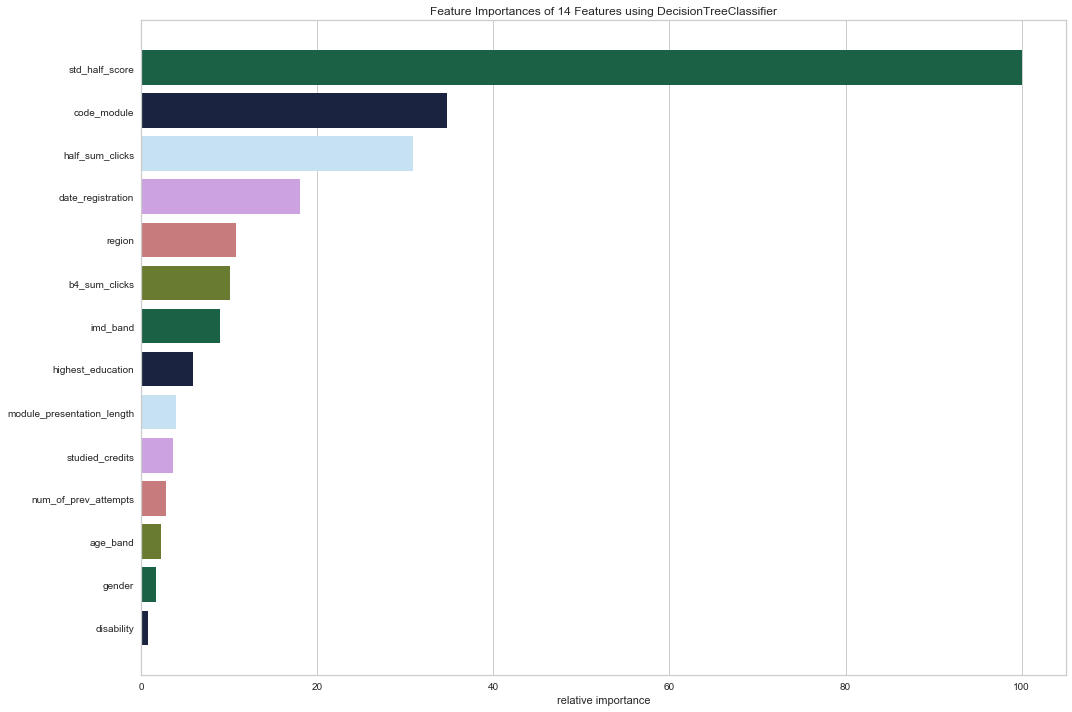

In [18]:
model = DecisionTreeClassifier()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

In [19]:
feature_list = RandomForestClassifier()
feature_list.fit(X, y)
predictions = feature_list.predict(X)
    
accuracy_score(y, predictions)

0.9907214542700247

GradientBoostingClassifier Feature Ranking

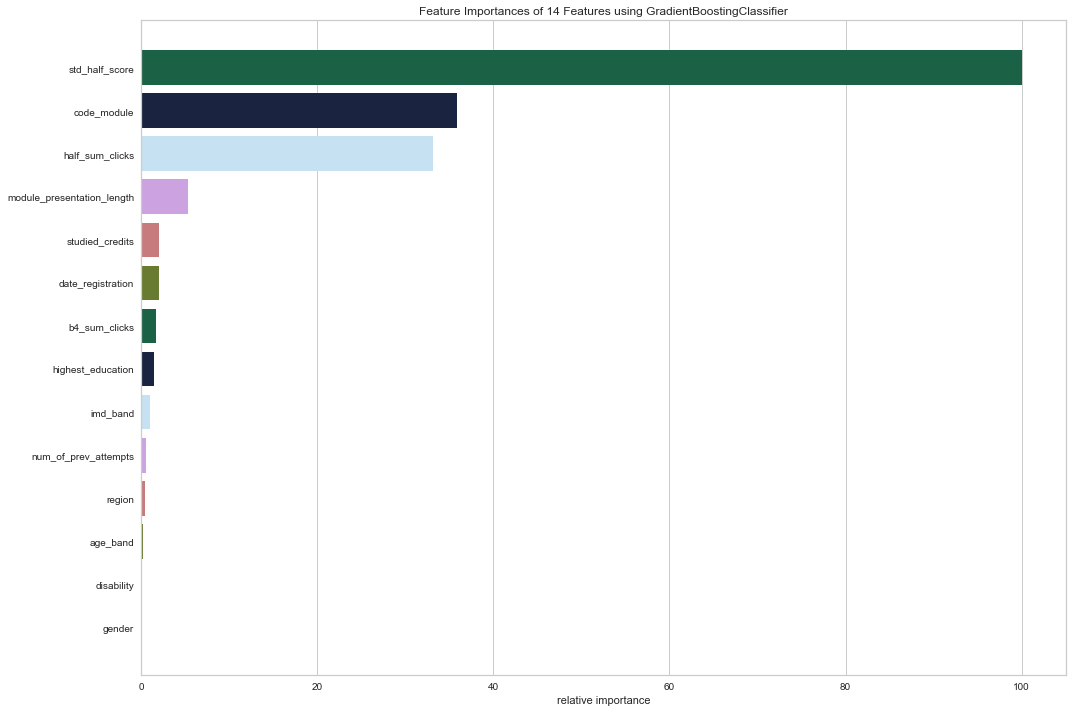

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
viz = FeatureImportances(model, size=(1080, 720))
viz.fit(X, y)
viz.show()

SVM Feature Ranking

//anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


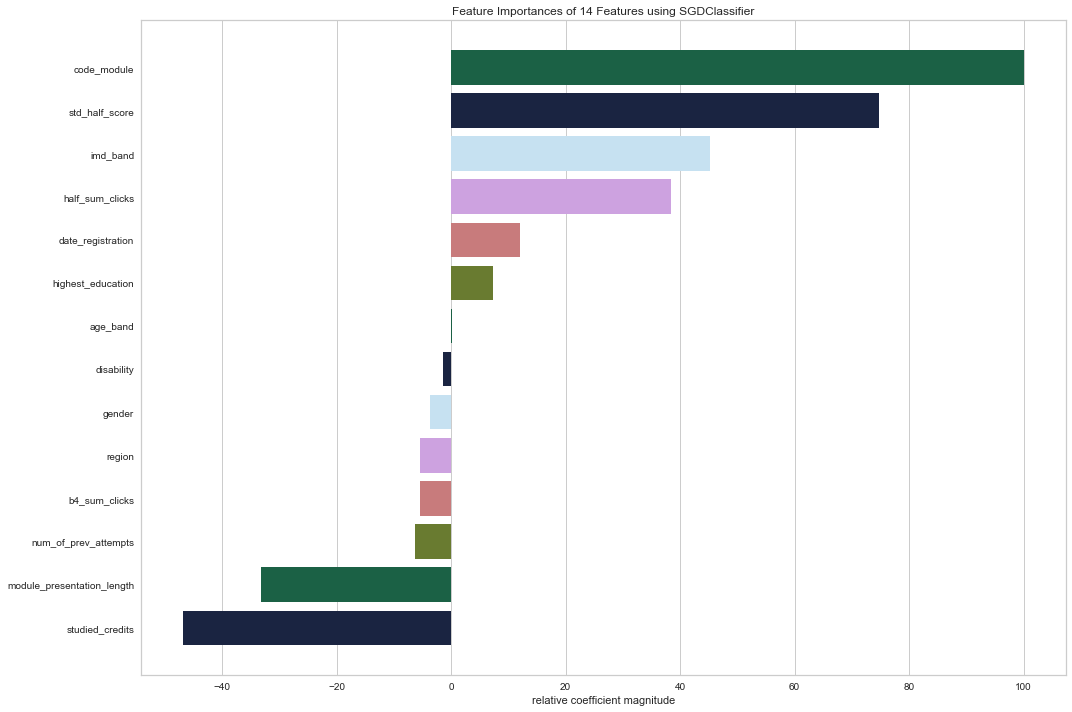

In [21]:
from sklearn import linear_model
model = linear_model.SGDClassifier()
viz = FeatureImportances(model, size=(1080, 720))
viz.fit(X, y)
viz.show()

Lasso Feature Ranking

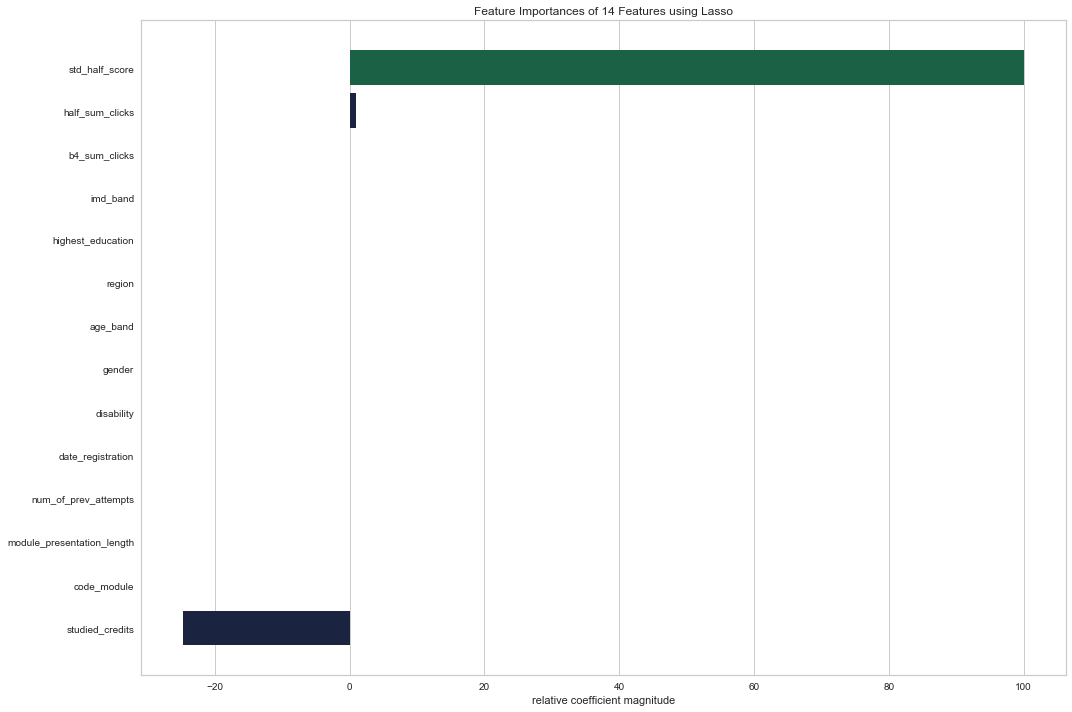

In [22]:
model = Lasso()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

# Additional Feature Analysis

Pearson Squares Feature Ranking (Excludes final_result)

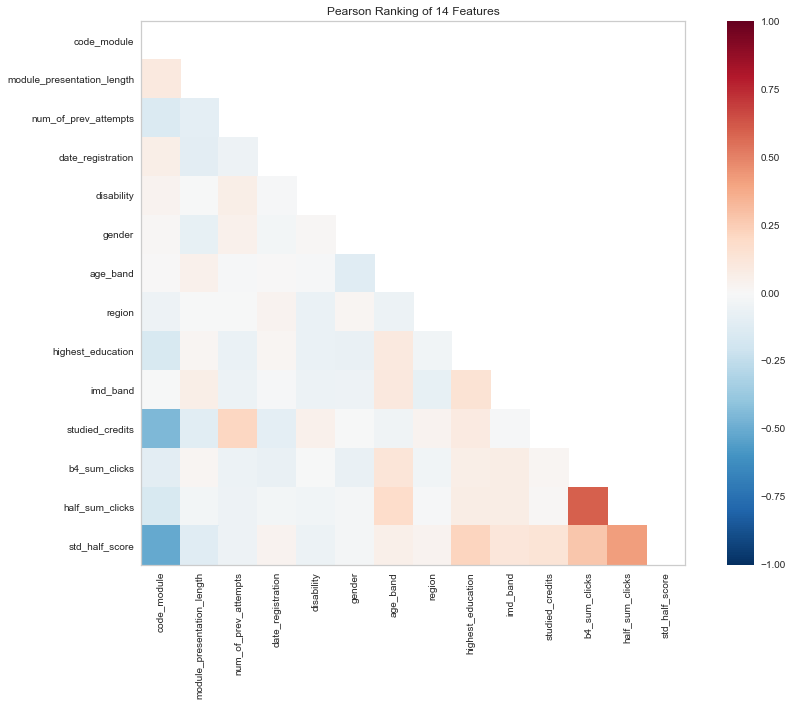

In [23]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [24]:
#features = feature_list[feature_list.columns.drop(['final_result'])]
#label = feature_list['final_result']

PCA Decomposition Analysis

//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
//anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


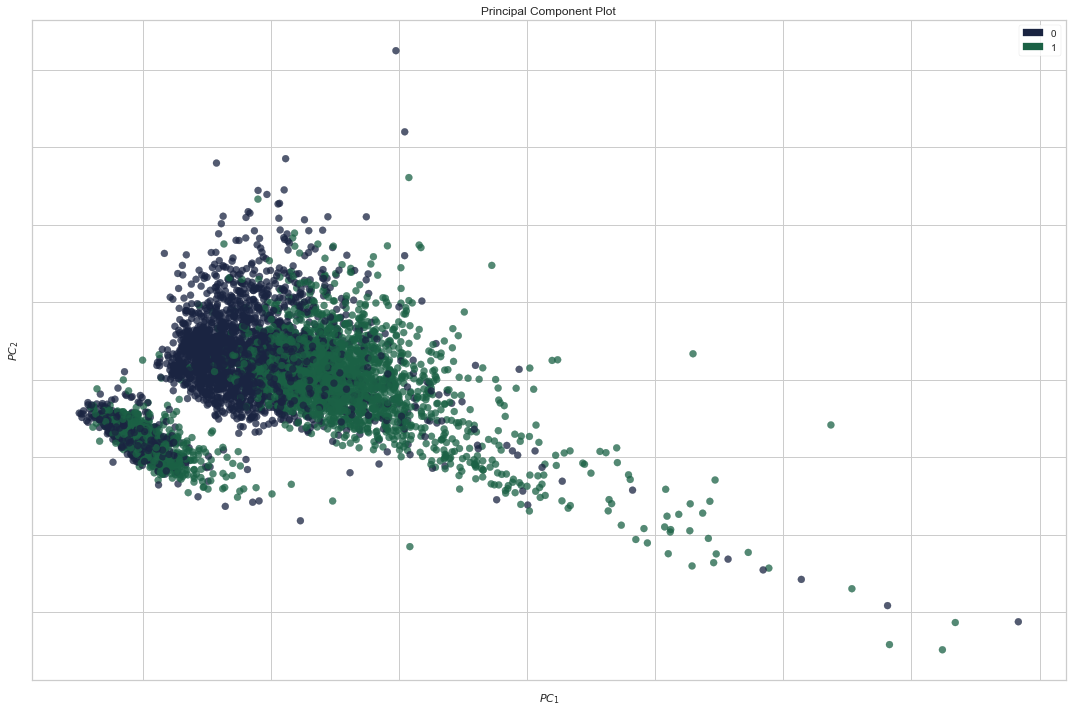

In [25]:
from yellowbrick.features.pca import PCADecomposition

# Create a list of colors to assign to points in the plot
colors = np.array(['r' if yi else 'b' for yi in y])

visualizer = PCADecomposition(
    scale=True, color=colors, size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

Manifold from Yellowbrick

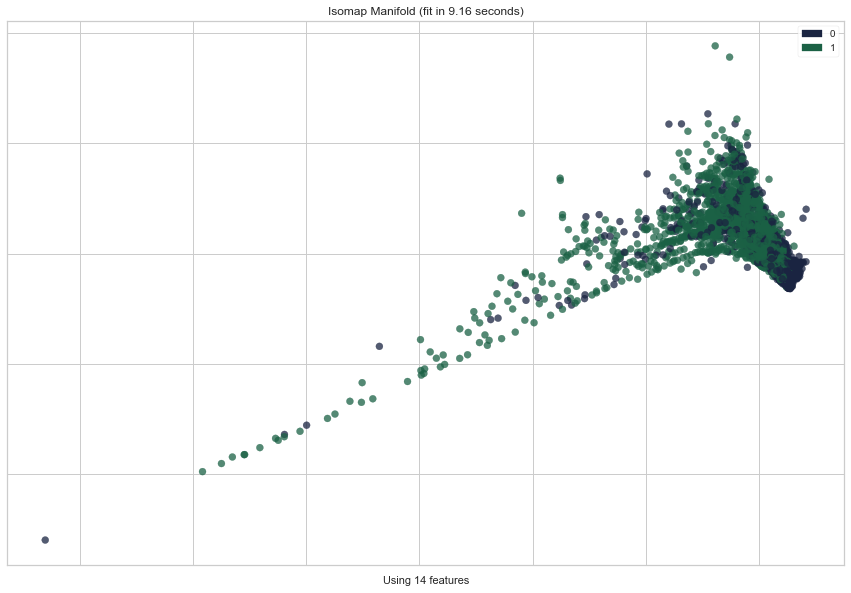

In [26]:
from yellowbrick.features.manifold import Manifold

visualizer = Manifold(
    manifold='isomap', n_neighbors=5, target='continuous', size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

# Regularization Techniques

In [27]:
features = X
labels   = y

In [28]:
list(features)

['code_module',
 'module_presentation_length',
 'num_of_prev_attempts',
 'date_registration',
 'disability',
 'gender',
 'age_band',
 'region',
 'highest_education',
 'imd_band',
 'studied_credits',
 'b4_sum_clicks',
 'half_sum_clicks',
 'std_half_score']

In [29]:
model = LinearRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.1232351793938621), ('module_presentation_length', 0.0042391564138763195), ('num_of_prev_attempts', -0.008422037015867589), ('date_registration', -0.0002477707561036699), ('disability', -0.007835557544522675), ('gender', -0.005191209970699414), ('age_band', 0.016528971822987383), ('region', 0.0024694488320616387), ('highest_education', 0.039169900544477075), ('imd_band', 0.008891290369472959), ('studied_credits', -5.9339408227848005e-05), ('b4_sum_clicks', -2.4121600222727662e-05), ('half_sum_clicks', 2.42450400956668e-05), ('std_half_score', 0.01108899461591713)]


In [30]:
model = Lasso()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.0), ('module_presentation_length', 0.0), ('num_of_prev_attempts', -0.0), ('date_registration', -0.0), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', 0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.0016596097519253805), ('b4_sum_clicks', 0.0), ('half_sum_clicks', 6.097337144573112e-05), ('std_half_score', 0.006722636246234631)]


In [31]:
model = Ridge()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.12322446865450769), ('module_presentation_length', 0.004239231126251221), ('num_of_prev_attempts', -0.008420700386900685), ('date_registration', -0.00024773739448938494), ('disability', -0.007819576758938001), ('gender', -0.00518700166221594), ('age_band', 0.016517670849874537), ('region', 0.0024691744871360257), ('highest_education', 0.03915388459564193), ('imd_band', 0.008892144829234755), ('studied_credits', -5.951831822710846e-05), ('b4_sum_clicks', -2.4115428788757026e-05), ('half_sum_clicks', 2.4247122883464628e-05), ('std_half_score', 0.0110887758273291)]


In [32]:
model = ElasticNet()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', 0.0), ('module_presentation_length', 0.0013321212097021278), ('num_of_prev_attempts', -0.0), ('date_registration', -0.0), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', -0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.0019447217818513894), ('b4_sum_clicks', 0.0), ('half_sum_clicks', 5.08166404485313e-05), ('std_half_score', 0.007328908129991041)]


In [33]:
model = LogisticRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', [0.8333692050578051, 0.003358128156506071, -0.16142622641602752, -0.0018410571930776538, -0.053844093155822184, -0.2334465994243834, 0.07115987994916897, 0.018511236508044027, 0.2889388869680051, 0.06597217137534181, -0.003302934426687066, -2.2212559093488347e-05, 0.00031222379452800267, 0.07638623697378392])]


In [34]:
model = linear_model.SGDClassifier()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', [1804.8460078820392, 26.63844694205242, -104.3643263757119, 82.10480221865348, -20.434972996642855, -51.087432491607096, 33.20683111954474, -59.115457597430556, 143.40972120858166, 842.9426361115183, -764.4869362137049, 142.67990074441417, -5.698550666521435e-14, 1375.2268712339333])]


# Transformer Techniques

In [35]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['studied_credits', 'half_sum_clicks', 'std_half_score']


In [36]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['code_module', 'age_band', 'highest_education']


In [37]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['module_presentation_length', 'studied_credits', 'std_half_score']


In [38]:
model = RandomForestClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['date_registration', 'b4_sum_clicks', 'half_sum_clicks', 'std_half_score']


In [39]:
model = DecisionTreeClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['code_module', 'date_registration', 'half_sum_clicks', 'std_half_score']


In [40]:
model = linear_model.SGDClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['code_module', 'imd_band', 'studied_credits', 'std_half_score']


In [41]:
model = LogisticRegression()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['code_module', 'num_of_prev_attempts', 'gender', 'highest_education']


In [42]:
model = GradientBoostingClassifier()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['code_module', 'half_sum_clicks', 'std_half_score']
